In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from RandomForestForTimeSeriesClassifier import RandomForestForTimeSeriesClassifier, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [2]:
dataset = pd.read_csv('../datasets/sp_500_stocks/sp500_stocks.csv') #, nrows=1000000)

In [3]:
dataset = dataset.dropna()
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
22524,2010-01-04,AMD,9.700000,9.700000,9.900000,9.680000,9.790000,18748700.0
22525,2010-01-05,AMD,9.710000,9.710000,9.900000,9.680000,9.710000,22145700.0
22526,2010-01-06,AMD,9.570000,9.570000,9.760000,9.550000,9.680000,18643400.0
22527,2010-01-07,AMD,9.470000,9.470000,9.550000,9.180000,9.510000,26806800.0
22528,2010-01-08,AMD,9.430000,9.430000,9.470000,9.290000,9.370000,13752800.0
...,...,...,...,...,...,...,...,...
1880749,2024-11-25,ZBRA,400.940002,400.940002,404.320007,398.130005,400.029999,420200.0
1880750,2024-11-26,ZBRA,402.450012,402.450012,403.570007,399.690002,402.440002,369200.0
1880751,2024-11-27,ZBRA,405.750000,405.750000,406.140015,400.929993,403.730011,258300.0
1880752,2024-11-29,ZBRA,407.000000,407.000000,409.029999,405.510010,406.640015,175700.0


In [4]:
dataset = dataset.loc[(dataset['Symbol'] == "AAPL") | (dataset['Symbol'] == "JNJ") | (dataset['Symbol'] == "JPM") | (dataset['Symbol'] == "XOM") | (dataset['Symbol'] == "PG") | (dataset['Symbol'] == "HD") | (dataset['Symbol'] == "T") | (dataset['Symbol'] == "UNP") | (dataset['Symbol'] == "DUK") | (dataset['Symbol'] == "AMT") | (dataset['Symbol'] == "MDLZ")]

In [5]:
dataset = dataset.sort_values("Date")
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
108866,2010-01-04,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0
1006072,2010-01-04,JPM,29.156572,42.849998,42.990002,41.669998,41.790001,35460500.0
108867,2010-01-05,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0
1006073,2010-01-05,JPM,29.721331,43.680000,43.840000,42.779999,42.790001,41208300.0
108868,2010-01-06,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0
...,...,...,...,...,...,...,...,...
112617,2024-11-27,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0
1009824,2024-11-29,JPM,249.720001,249.720001,251.770004,249.449997,249.860001,5494800.0
112618,2024-11-29,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0
112619,2024-12-02,AMT,207.330002,207.330002,208.509995,205.710007,207.539993,2363317.0


In [6]:
from datetime import datetime, timedelta
dateFormat = "%Y-%m-%d"

def calculateAvgVolatility(row0, days, dateList, volatilityHistory, volatility):
    if len(dateList) == 0:
        dateList.append(row0['Date'])
        volatilityHistory.append((row0['High'] - row0['Low']) / row0['Low'])
    else:
        pivoteDate = dateList[0]

        listVoid = False
        while datetime.strptime(pivoteDate, dateFormat) + timedelta(days=days) <= datetime.strptime(row0['Date'], dateFormat) and not listVoid:
            dateList.pop(0)
            volatilityHistory.pop(0)
            if len(dateList) > 0:
                pivoteDate = dateList[0]
            else:
                listVoid = True

        dateList.append(row0['Date'])
        volatilityHistory.append((row0['High'] - row0['Low']) / row0['Low'])
    volatility.append(sum(volatilityHistory) / len(volatilityHistory))

In [7]:
groupedBySymbol = dataset.groupby('Symbol')

symbols = []
dates = []
volatility14 = []
volatility30 = []
volatility90 = []
#datetime.strptime(date, format) + timedelta(days=days) > datetime.today()
for symbol, group0 in groupedBySymbol:
    group0 = group0.reset_index()  # make sure indexes pair with number of rows
    datesIn14Days = []
    datesIn30Days = []
    datesIn90Days = []
    volatility14History = []
    volatility30History = []
    volatility90History = []

    for index, row in group0.iterrows():

        symbols.append(symbol)
        dates.append(row["Date"])

        calculateAvgVolatility(row, 14, datesIn14Days, volatility14History, volatility14)
        calculateAvgVolatility(row, 30, datesIn30Days, volatility30History, volatility30)
        calculateAvgVolatility(row, 90, datesIn90Days, volatility90History, volatility90)


In [8]:
data = {
    'Symbol': symbols,
    'Date': dates,
    'Volatility14': volatility14,
    'Volatility30': volatility30,
    'Volatility90': volatility90,
}

dfVolatility = pd.DataFrame(data)
new_df = pd.merge(
    left=dataset,
    right=dfVolatility,
    how='left',
    left_on=['Date', 'Symbol'],
    right_on=['Date', 'Symbol'],
)
new_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Volatility14,Volatility30,Volatility90
0,2010-01-04,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0,0.014094,0.014094,0.014094
1,2010-01-04,JPM,29.156572,42.849998,42.990002,41.669998,41.790001,35460500.0,0.031678,0.031678,0.031678
2,2010-01-05,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0,0.016840,0.016840,0.016840
3,2010-01-05,JPM,29.721331,43.680000,43.840000,42.779999,42.790001,41208300.0,0.028228,0.028228,0.028228
4,2010-01-06,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0,0.017243,0.017243,0.017243
...,...,...,...,...,...,...,...,...,...,...,...
7503,2024-11-27,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0,0.016718,0.023014,0.020162
7504,2024-11-29,JPM,249.720001,249.720001,251.770004,249.449997,249.860001,5494800.0,0.016835,0.019024,0.019613
7505,2024-11-29,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0,0.016165,0.021675,0.020028
7506,2024-12-02,AMT,207.330002,207.330002,208.509995,205.710007,207.539993,2363317.0,0.014827,0.019972,0.019612


In [9]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Date'] = new_df['Date'].map(dt.datetime.toordinal)
new_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Volatility14,Volatility30,Volatility90
0,733776,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0,0.014094,0.014094,0.014094
1,733776,JPM,29.156572,42.849998,42.990002,41.669998,41.790001,35460500.0,0.031678,0.031678,0.031678
2,733777,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0,0.016840,0.016840,0.016840
3,733777,JPM,29.721331,43.680000,43.840000,42.779999,42.790001,41208300.0,0.028228,0.028228,0.028228
4,733778,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0,0.017243,0.017243,0.017243
...,...,...,...,...,...,...,...,...,...,...,...
7503,739217,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0,0.016718,0.023014,0.020162
7504,739219,JPM,249.720001,249.720001,251.770004,249.449997,249.860001,5494800.0,0.016835,0.019024,0.019613
7505,739219,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0,0.016165,0.021675,0.020028
7506,739222,AMT,207.330002,207.330002,208.509995,205.710007,207.539993,2363317.0,0.014827,0.019972,0.019612


In [10]:
from sklearn import preprocessing

Y = new_df.pop("Symbol")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(new_df)
normalized_dataset = pd.DataFrame(x_scaled)

normalized_dataset

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.052122,0.054789,0.053753,0.057038,0.055570,0.010440,0.057551,0.056256,0.067904
1,0.000000,0.036432,0.052572,0.050475,0.051087,0.049371,0.161312,0.215498,0.276319,0.478510
2,0.000184,0.054263,0.057404,0.055064,0.057482,0.055606,0.009634,0.082213,0.090617,0.132016
3,0.000184,0.038632,0.055588,0.053571,0.055190,0.053017,0.187823,0.184509,0.233143,0.397950
4,0.000367,0.054948,0.058240,0.056193,0.058850,0.058304,0.012584,0.085833,0.095661,0.141428
...,...,...,...,...,...,...,...,...,...,...
7503,0.999082,0.738155,0.657317,0.657489,0.665311,0.655424,0.005454,0.081117,0.167896,0.209590
7504,0.999449,0.895605,0.804171,0.810809,0.819163,0.808058,0.023098,0.082170,0.117951,0.196780
7505,0.999449,0.736986,0.656227,0.657854,0.664202,0.660164,0.005181,0.076151,0.151138,0.206476
7506,1.000000,0.730481,0.650160,0.653265,0.657475,0.653747,0.008654,0.064132,0.129819,0.196748


In [11]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [12]:
aux = normalized_dataset.copy()

#Y = aux.pop("Symbol")

X = aux.copy()
#dataset = aux

X_train = X.iloc[:trainSamples]
Y_train = Y.iloc[:trainSamples]
X_test = X.iloc[-testSamples:]
Y_test = Y.iloc[-testSamples:]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)
#
#X_train = X_train.values.reshape(-1, 1)
#X_test = X_test.values.reshape(-1, 1)
X_train

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.052122,0.054789,0.053753,0.057038,0.055570,0.010440,0.057551,0.056256,0.067904
1,0.000000,0.036432,0.052572,0.050475,0.051087,0.049371,0.161312,0.215498,0.276319,0.478510
2,0.000184,0.054263,0.057404,0.055064,0.057482,0.055606,0.009634,0.082213,0.090617,0.132016
3,0.000184,0.038632,0.055588,0.053571,0.055190,0.053017,0.187823,0.184509,0.233143,0.397950
4,0.000367,0.054948,0.058240,0.056193,0.058850,0.058304,0.012584,0.085833,0.095661,0.141428
...,...,...,...,...,...,...,...,...,...,...
5995,0.798201,0.874288,0.866735,0.874686,0.863670,0.860091,0.006254,0.119960,0.149377,0.204009
5996,0.798384,0.491682,0.473950,0.478896,0.482182,0.477338,0.085032,0.100263,0.080349,0.147210
5997,0.798384,0.858392,0.850531,0.870461,0.866886,0.860201,0.010482,0.127708,0.149696,0.204001
5998,0.798568,0.845810,0.837705,0.868240,0.852654,0.859544,0.009880,0.140236,0.155960,0.210420


In [13]:
basicRF = RandomForestClassifier(n_jobs=10, n_estimators=500, max_depth=10)

In [14]:
basicRF.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=10)

In [15]:
# Realizar predicciones sobre los datos de prueba
y_pred = basicRF.predict(X_test)

In [16]:
from sklearn import metrics

print("Precisión:")
print(metrics.accuracy_score(Y_test, y_pred))

Precisión:
0.8594164456233422


In [17]:
rf_precision = metrics.accuracy_score(Y_test, y_pred)

In [18]:
count_row = dataset.shape[0]
#block_size = int(math.sqrt(count_row))
block_size = int(count_row // 100)

In [19]:
rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=100, block_size=block_size, max_depth=10)

In [20]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [21]:
rfts.fit(X_train, Y_train)

RandomForestForTimeSeriesClassifier(block_size=75, max_depth=10, n_jobs=10)

In [22]:
y_pred = rfts.predict(X_test)

In [23]:
print("Precisión:")
print(metrics.accuracy_score(Y_test, y_pred))

Precisión:
0.9734748010610079


In [24]:
precision = dict()
for i in range(10, 100):
    block_size = i #int(count_row // i)
    rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    print(f"Precisión: ({i}, {block_size})")
    print(metrics.accuracy_score(Y_test, y_pred))
    precision[i] = (block_size, metrics.accuracy_score(Y_test, y_pred))

Precisión: (10, 10)
0.980106100795756
Precisión: (11, 11)
0.976790450928382
Precisión: (12, 12)
0.9728116710875332
Precisión: (13, 13)
0.9774535809018567
Precisión: (14, 14)
0.9728116710875332
Precisión: (15, 15)
0.9787798408488063
Precisión: (16, 16)
0.9781167108753316
Precisión: (17, 17)
0.9781167108753316
Precisión: (18, 18)
0.9807692307692307
Precisión: (19, 19)
0.9761273209549072
Precisión: (20, 20)
0.9748010610079576
Precisión: (21, 21)
0.9734748010610079
Precisión: (22, 22)
0.976790450928382
Precisión: (23, 23)
0.9741379310344828
Precisión: (24, 24)
0.9714854111405835
Precisión: (25, 25)
0.9734748010610079
Precisión: (26, 26)
0.9781167108753316
Precisión: (27, 27)
0.9748010610079576
Precisión: (28, 28)
0.9741379310344828
Precisión: (29, 29)
0.9774535809018567
Precisión: (30, 30)
0.9708222811671088
Precisión: (31, 31)
0.976790450928382
Precisión: (32, 32)
0.9535809018567639
Precisión: (33, 33)
0.9807692307692307
Precisión: (34, 34)
0.9781167108753316
Precisión: (35, 35)
0.9781167

In [25]:
rfts_alter = TimeSeriesForest(n_jobs=10, n_estimators=100, max_depth=10)
rfts_alter.fit(X_train, Y_train)

TimeSeriesForest(max_depth=10, n_estimators=100, n_jobs=10)

In [26]:
y_pred = rfts_alter.predict(X_test)

In [27]:
print("Precisión:")
print(metrics.accuracy_score(Y_test, y_pred))

Precisión:
0.866710875331565


In [28]:
rfts_alter_precision = metrics.accuracy_score(Y_test, y_pred)

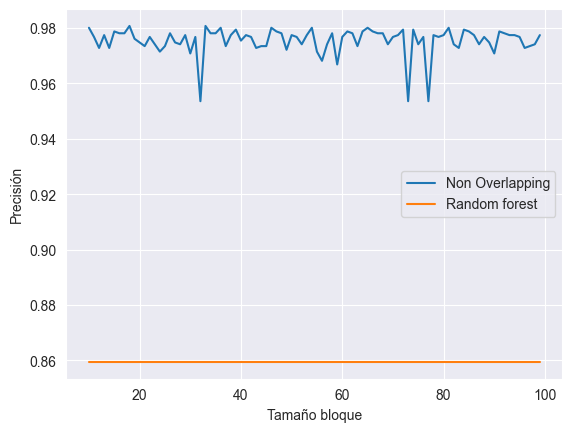

In [29]:
from matplotlib import pyplot as plt

plt_x = []
plt_y = []

for r in precision:
    plt_x.append(precision[r][0])
    plt_y.append(precision[r][1])

plt.plot(plt_x, plt_y, label ='Non Overlapping')

plt_x = []
plt_y = []

for r in precision:
    plt_x.append(precision[r][0])
    plt_y.append(rf_precision)

plt.plot(plt_x, plt_y, '-', label ='Random forest')

plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")
plt.legend()
plt.show()

In [30]:
precision2 = dict()
for i in range(10, 100):
    block_size = i #int(count_row // i)
    rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=i, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    print(f"Precisión: ({i}, {block_size})")
    print(metrics.accuracy_score(Y_test, y_pred))
    precision2[i] = (block_size, metrics.accuracy_score(Y_test, y_pred))

Precisión: (10, 10)
0.8587533156498673
Precisión: (11, 11)
0.8594164456233422
Precisión: (12, 12)
0.8594164456233422
Precisión: (13, 13)
0.8587533156498673
Precisión: (14, 14)
0.8759946949602122
Precisión: (15, 15)
0.9449602122015915
Precisión: (16, 16)
0.9283819628647215
Precisión: (17, 17)
0.8594164456233422
Precisión: (18, 18)
0.9602122015915119
Precisión: (19, 19)
0.8594164456233422
Precisión: (20, 20)
0.860079575596817
Precisión: (21, 21)
0.8594164456233422
Precisión: (22, 22)
0.9118037135278515
Precisión: (23, 23)
0.8567639257294429
Precisión: (24, 24)
0.8587533156498673
Precisión: (25, 25)
0.8580901856763926
Precisión: (26, 26)
0.8594164456233422
Precisión: (27, 27)
0.8587533156498673
Precisión: (28, 28)
0.8919098143236074
Precisión: (29, 29)
0.8759946949602122
Precisión: (30, 30)
0.8580901856763926
Precisión: (31, 31)
0.9409814323607427
Precisión: (32, 32)
0.9429708222811671
Precisión: (33, 33)
0.8620689655172413
Precisión: (34, 34)
0.9190981432360743
Precisión: (35, 35)
0.9303

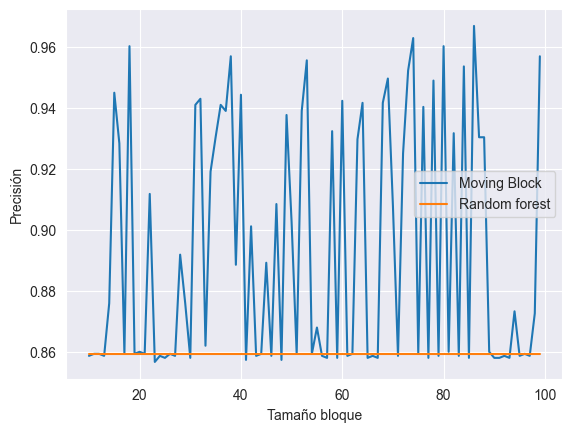

In [31]:
plt_x = []
plt_y = []

for r in precision2:
    plt_x.append(precision2[r][0])
    plt_y.append(precision2[r][1])

plt.plot(plt_x, plt_y, label ='Moving Block')

plt_x = []
plt_y = []
for r in precision:
    plt_x.append(precision2[r][0])
    plt_y.append(rf_precision)

plt.plot(plt_x, plt_y, '-', label ='Random forest')

plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")
plt.legend()
plt.show()

In [32]:
precision3 = dict()
for i in range(10, 100):
    block_size = i #int(count_row // i)
    rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=i, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    print(f"Precisión: ({i}, {block_size})")
    print(metrics.accuracy_score(Y_test, y_pred))
    precision3[i] = (block_size, metrics.accuracy_score(Y_test, y_pred))

Precisión: (10, 10)
0.9489389920424404
Precisión: (11, 11)
0.9356763925729443
Precisión: (12, 12)
0.9608753315649867
Precisión: (13, 13)
0.9237400530503979
Precisión: (14, 14)
0.8594164456233422
Precisión: (15, 15)
0.9310344827586207
Precisión: (16, 16)
0.8580901856763926
Precisión: (17, 17)
0.8587533156498673
Precisión: (18, 18)
0.8587533156498673
Precisión: (19, 19)
0.9303713527851459
Precisión: (20, 20)
0.8587533156498673
Precisión: (21, 21)
0.873342175066313
Precisión: (22, 22)
0.9555702917771883
Precisión: (23, 23)
0.9529177718832891
Precisión: (24, 24)
0.9297082228116711
Precisión: (25, 25)
0.9290450928381963
Precisión: (26, 26)
0.8580901856763926
Precisión: (27, 27)
0.9555702917771883
Precisión: (28, 28)
0.9396551724137931
Precisión: (29, 29)
0.9350132625994695
Precisión: (30, 30)
0.8925729442970822
Precisión: (31, 31)
0.9575596816976127
Precisión: (32, 32)
0.8580901856763926
Precisión: (33, 33)
0.9675066312997348
Precisión: (34, 34)
0.9376657824933687
Precisión: (35, 35)
0.8587

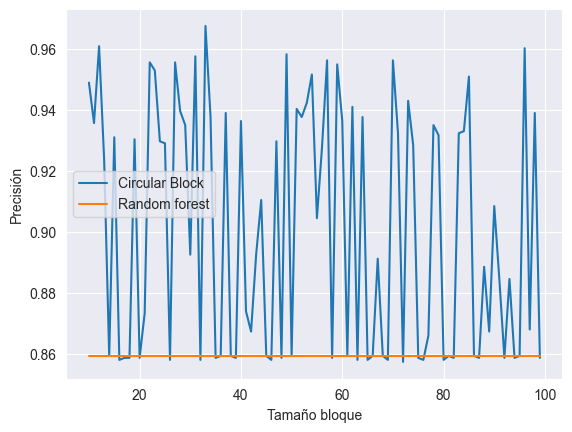

In [33]:
plt_x = []
plt_y = []

for r in precision3:
    plt_x.append(precision3[r][0])
    plt_y.append(precision3[r][1])

plt.plot(plt_x, plt_y, label ='Circular Block')

plt_x = []
plt_y = []
for r in precision:
    plt_x.append(precision2[r][0])
    plt_y.append(rf_precision)

plt.plot(plt_x, plt_y, '-', label ='Random forest')

plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")
plt.legend()
plt.show()

In [34]:
rftstpMov = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=100, max_depth=10, block_size=30, block_type=BLOCK_TYPES[1])
rftstpMov.fit(X_train, Y_train)

RandomForestForTimeSeriesClassifier(block_size=30, block_type='moving-block',
                                    max_depth=10, n_jobs=10)

In [35]:
y_pred = rftstpMov.predict(X_test)

In [36]:
print("Precisión:")
print(metrics.accuracy_score(Y_test, y_pred))

Precisión:
0.963527851458886


In [37]:
rftstpCir = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=100, max_depth=10, block_size=30, block_type=BLOCK_TYPES[2])
rftstpCir.fit(X_train, Y_train)

RandomForestForTimeSeriesClassifier(block_size=30, block_type='circular-block',
                                    max_depth=10, n_jobs=10)

In [38]:
y_pred = rftstpCir.predict(X_test)

In [39]:
print("Precisión:")
print(metrics.accuracy_score(Y_test, y_pred))

Precisión:
0.8594164456233422


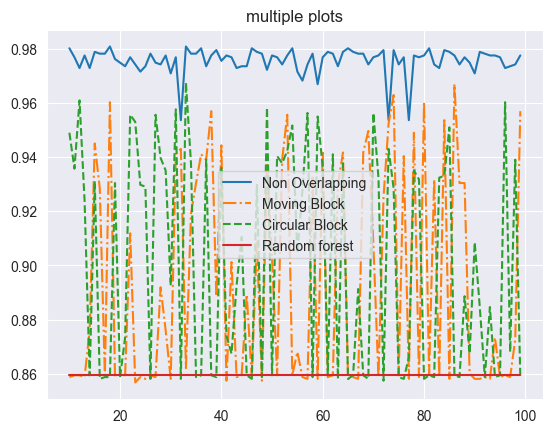

In [40]:
plt_x = []
plt_y = []

for r in precision:
    plt_x.append(precision[r][0])
    plt_y.append(precision[r][1])

plt.plot(plt_x, plt_y, label ='Non Overlapping')

plt_x = []
plt_y = []

for r in precision2:
    plt_x.append(precision2[r][0])
    plt_y.append(precision2[r][1])

plt.plot(plt_x, plt_y, '-.', label ='Moving Block')

plt_x = []
plt_y = []

for r in precision3:
    plt_x.append(precision3[r][0])
    plt_y.append(precision3[r][1])

plt.plot(plt_x, plt_y, '--', label ='Circular Block')


plt_x = []
plt_y = []

for r in precision3:
    plt_x.append(precision3[r][0])
    plt_y.append(rf_precision)

plt.plot(plt_x, plt_y, '-', label ='Random forest')

plt.legend()
plt.title('multiple plots')
plt.show()

([<matplotlib.axis.XTick at 0x1a8e9696b10>,
 [Text(0, 0, 'Non Overlapping'),
  Text(1, 0, 'Moving Block'),
  Text(2, 0, 'Circular Block')])

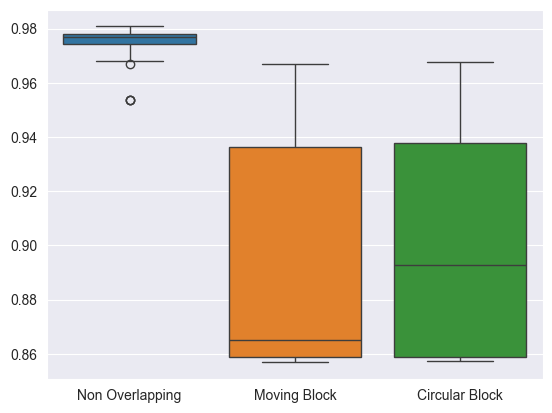

In [41]:
data1 = []
for r in precision:
    data1.append(precision[r][1])
data2 = []
for r in precision2:
    data2.append(precision2[r][1])
data3 = []
for r in precision3:
    data3.append(precision3[r][1])

all_arr = [data1,
           data2,
           data3]
sns.boxplot(data=all_arr)
plt.xticks([0, 1, 2], ["Non Overlapping", "Moving Block", "Circular Block"])